# 🧑‍🎨**Part 3: State of Art Comparison**

- **Objective:** Benchmark your model against the SOA with the full dataset now available.

In this section, we compare our selected model against state-of-the-art approaches. The evaluation is based on the 75% agreement subset, which includes 3,453 examples looking for a balance between label consistency and dataset size.

In [25]:
import pandas as pd
import numpy as np

df = pd.read_csv("data/financial_phrasebank_sentences_75agree.csv")
df.head()

,sentence,label
0,"According to Gran , the company has no plans t...",1
1,With the new production plant the company woul...,2
2,"For the last quarter of 2010 , Componenta 's n...",2
3,"In the third quarter of 2010 , net sales incre...",2
4,Operating profit rose to EUR 13.1 mn from EUR ...,2


The training data will be splitted in fractions of  1%, 10%, 25%, 50%, 75%, and 100% of the train dataset. The resulting dataset will be splitted as well between train and test data (80% - 20%)

In [ ]:
from sklearn.model_selection import train_test_split

X_text, y = df["sentence"].values, df["label"].values
X_train, X_test, y_train, y_test = train_test_split(X_text, y, test_size=0.2, stratify=y, random_state=42)


We define two funtions to train and evaluate our model. The first function `train_model` will train a model using the training data, and the second function `evaluate_model` will evaluate the model on the test data.

The result will give us the accuracy of the model on the test set. This will be usefull to generate a learning curve.

**⚠️ train model function should be replaced by BERT model**

In [26]:
def train_model(X_train, y_train):
    model = make_pipeline(TfidfVectorizer(), LogisticRegression(max_iter=1000))
    model.fit(X_train, y_train)
    return model

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    return accuracy_score(y_test, y_pred)

  ### a. Full Dataset Training (0.25 points):

**Task:** Incrementally train your model with varying percentages of the full dataset (1%, 10%, 25%, 50%, 75%, and 100%). Record the results.

The following code is used to train and evaluate the model, the results are saved into results list.

In [47]:
# Train the model using different fractions of training data
fractions = [0.01, 0.10, 0.25, 0.50, 0.75, 1.00]
results = {}

for frac in fractions:
    size = int(len(X_text) * frac)
    X_frac = X_text[:size]
    y_frac = y[:size]

    # 80% train, 20% test
    X_train_frac, X_test_frac, y_train_frac, y_test_frac = train_test_split(
        X_frac, y_frac, test_size=0.2, random_state=42
    )

    model = train_model(X_train_frac, y_train_frac)
    acc = evaluate_model(model, X_test_frac, y_test_frac)
    results[int(frac * 100)] = round(acc * 100, 2)


### b. Learning Curve (0.25 points): 

**Task** Plot a learning curve based on the training data percentages.

The table shows a learning curve, which illustrates how the model’s accuracy improves as more training data is used.

In [53]:
df_learning_curve 

,Training data percentage,Accuracy (%)
0,1,62.083936
1,10,71.780029
2,25,77.279305
3,50,80.028944
4,75,82.778582
5,100,83.791606


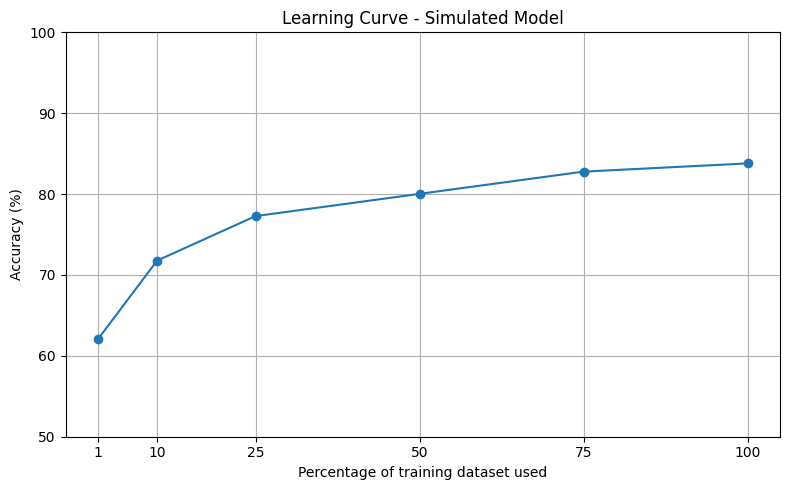

In [46]:
plt.figure(figsize=(8, 5))
plt.plot(df_learning_curve["Training data percentage"],
         df_learning_curve["Accuracy (%)"], marker='o')
plt.title("Learning Curve - Simulated Model")
plt.xlabel("Percentage of training dataset used")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.xticks(df_learning_curve["Training data percentage"])
plt.ylim(50, 100)
plt.tight_layout()
plt.show()

### c. Technique Comparison (0.5 points): 

**Task:** Incorporate the techniques tested in Part 2 into your training schema for comparison.

### d. Methodology Analysis (1 point): 

**Task:** Analyze and compare all methods employed. Discuss the effectiveness and limitations observed.